In [2]:
import csv, json 
import os.path
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import librosa
import librosa.display
import IPython.display as ipd
import math

# use LateX fonts
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica"
})


# Initialize constants

In [3]:
AUDIO_FEATURES = ['f0_mean', 'f0_range', 'rmse_mean', 'zcr_mean', 'f0_std', 'centroid_mean', 'spec_bw_mean', 'rolloff_mean']
PATH_TO_AUDIO = "interviews/"
FILE_NAME_SUFFIX = "_AUDIO_SLICED.wav" #suffix for interview audio files
PHQ_CSV_FILE = "participants_info/phq_scores.csv"
PARTICIPANTS_INFO = {} #/PHQ-cores and gender of every participant
PARTICIPANTS_INFO_EXIST_ON_DISK = False
SAMPLING_RATE = 16000
SPLIT_FREQUENCY = 500

FRAME_SIZE_SEC = 0.025
FRAME_SIZE = int(SAMPLING_RATE*FRAME_SIZE_SEC)
HOP_LENGTH = int(FRAME_SIZE/4)



# check if feature extraction results already exist on disk

In [4]:
if os.path.exists('extracted_feature_results/results.json'):
    PARTICIPANTS_INFO_EXIST_ON_DISK = True
    with open('extracted_feature_results/results.json', 'r') as jsonFile:
        PARTICIPANTS_INFO = json.load(jsonFile)
    print(PARTICIPANTS_INFO_EXIST_ON_DISK)
   

# Loading participants phq scores

In [5]:
def createParticipantInfoFromCsv(csv_file: str) -> dict:
    outer_dict = {}
    with open(csv_file) as csvFile:
        csv_reader = csv.reader(csvFile, delimiter=',')
        line_count = 0
        for row in csv_reader:
            line_count += 1
            if line_count == 1:
                continue
            inner_dict = {}
            inner_dict.update({"phq_score": row[3]})
            inner_dict.update({"gender": row[1]})

            outer_dict[row[0]] = inner_dict
        
    return outer_dict

# store info in dict

In [6]:
if PARTICIPANTS_INFO_EXIST_ON_DISK == False:
    PARTICIPANTS_INFO = createParticipantInfoFromCsv(PHQ_CSV_FILE)

# Loading audio Files

In [8]:
if PARTICIPANTS_INFO_EXIST_ON_DISK == False:
    for k, v in PARTICIPANTS_INFO.items():
        y, _ = librosa.load(f"{PATH_TO_AUDIO}{k}{FILE_NAME_SUFFIX}", sr=SAMPLING_RATE)
        length = librosa.get_duration(y=y, sr=SAMPLING_RATE)
        offset = length/2
        loaded_audio, _ = librosa.load(f"{PATH_TO_AUDIO}{k}{FILE_NAME_SUFFIX}", sr=SAMPLING_RATE, offset=offset,
                                       duration=30.0)
        v.update({"loaded_audio_30s": loaded_audio})
        print(f"loaded audio file for participant {k}!")
    print("loaded all audio files with librosa!")

loaded audio file for participant 300!
loaded audio file for participant 301!
loaded audio file for participant 306!
loaded audio file for participant 317!
loaded audio file for participant 320!
loaded audio file for participant 321!
loaded audio file for participant 331!
loaded audio file for participant 334!
loaded audio file for participant 336!
loaded audio file for participant 343!
loaded audio file for participant 344!
loaded audio file for participant 347!
loaded audio file for participant 350!
loaded audio file for participant 365!
loaded audio file for participant 371!
loaded audio file for participant 373!
loaded audio file for participant 374!
loaded audio file for participant 381!
loaded audio file for participant 382!
loaded audio file for participant 388!
loaded audio file for participant 393!
loaded audio file for participant 401!
loaded audio file for participant 402!
loaded audio file for participant 408!
loaded audio file for participant 412!
loaded audio file for par

loaded audio file for participant 463!
loaded audio file for participant 464!
loaded audio file for participant 466!
loaded audio file for participant 467!
loaded audio file for participant 469!
loaded audio file for participant 470!
loaded audio file for participant 471!
loaded audio file for participant 472!
loaded audio file for participant 474!
loaded audio file for participant 476!
loaded audio file for participant 477!
loaded audio file for participant 478!
loaded audio file for participant 481!
loaded audio file for participant 482!
loaded audio file for participant 483!
loaded audio file for participant 485!
loaded audio file for participant 487!
loaded audio file for participant 488!
loaded audio file for participant 489!
loaded audio file for participant 490!
loaded audio file for participant 491!
loaded audio file for participant 492!
loaded audio file for participant 601!
loaded audio file for participant 603!
loaded audio file for participant 608!
loaded audio file for par

In [9]:
print(len(PARTICIPANTS_INFO))

274


# functions for calculating band energy ratio

In [7]:
def calculate_split_frequency_bin(split_frequency, sample_rate, num_frequency_bins):
    """Infer the frequency bin associated to a given split frequency."""
    
    frequency_range = sample_rate / 2
    frequency_delta_per_bin = frequency_range / num_frequency_bins
    split_frequency_bin = math.floor(split_frequency / frequency_delta_per_bin)
    return int(split_frequency_bin)

In [5]:
# map split frequency to frequency bin
def band_energy_ratio(spectrogram, split_frequency, sample_rate):
    """Calculate band energy ratio with a given split frequency."""
    
    split_frequency_bin = calculate_split_frequency_bin(split_frequency, sample_rate, len(spectrogram[0]))
    band_energy_ratio = []
    
    # calculate power spectrogram
    power_spectrogram = np.abs(spectrogram) ** 2
    power_spectrogram = power_spectrogram.T
    
    # calculate BER value for each frame
    for frame in power_spectrogram:
        sum_power_low_frequencies = frame[:split_frequency_bin].sum()
        sum_power_high_frequencies = frame[split_frequency_bin:].sum()
        band_energy_ratio_current_frame = sum_power_low_frequencies / sum_power_high_frequencies
        band_energy_ratio.append(band_energy_ratio_current_frame)
    
    return np.array(band_energy_ratio)

# calculate audio features

In [10]:
if PARTICIPANTS_INFO_EXIST_ON_DISK == False:
    for k, v in PARTICIPANTS_INFO.items():
        rmse_audio = librosa.feature.rms(y=v['loaded_audio_30s'], frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
        #rmse_median = np.median(rmse_audio)
        rmse_mean = np.mean(rmse_audio)
        zcr_audio = librosa.feature.zero_crossing_rate(v['loaded_audio_30s'], frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
        #zcr_median = np.median(zcr_audio)
        zcr_mean = np.mean(zcr_audio)
        f0, _, _ = librosa.pyin(v['loaded_audio_30s'], fmin=50, fmax=500, frame_length=FRAME_SIZE, 
                                hop_length=HOP_LENGTH, sr=SAMPLING_RATE)
        f0_no_nans = f0[~np.isnan(f0)]
        f0_std = np.std(f0_no_nans)
        #f0_median = np.median(f0_no_nans)
        f0_mean = np.mean(f0_no_nans)
        f0_range = np.max(f0_no_nans) - np.min(f0_no_nans)
        centroid = librosa.feature.spectral_centroid(y=v['loaded_audio_30s'], sr=SAMPLING_RATE,
                                                    n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)
        centroid_mean = np.mean(centroid)
        spec_bw = librosa.feature.spectral_bandwidth(y=v['loaded_audio_30s'], sr=SAMPLING_RATE,
                                                    n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)
        spec_bw_mean = np.mean(spec_bw)
        rolloff = librosa.feature.spectral_rolloff(y=v['loaded_audio_30s'], sr=SAMPLING_RATE,
                                                  n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)
        rolloff_mean = np.mean(rolloff)

        #v.update({"f0_median": f0_median})
        v.update({"f0_mean": f0_mean})
        v.update({"f0_range": f0_range})
        v.update({"f0_std": f0_std})
        #v.update({"zcr_median": zcr_median})
        v.update({"zcr_mean": zcr_mean})
        #v.update({"rmse_median": rmse_median})
        v.update({"rmse_mean": rmse_mean})
        v.update({"centroid_mean": centroid_mean})
        v.update({"spec_bw_mean": spec_bw_mean})
        v.update({"rolloff_mean": rolloff_mean})
        #v.update({"ber_median": ber_median})
        #v.update({"ber_mean": ber_mean})
        print(f"calculated audio features for participant {k}!")
    print("calculated all audio features with librosa!")

calculated audio features for participant 300!
calculated audio features for participant 301!
calculated audio features for participant 306!
calculated audio features for participant 317!
calculated audio features for participant 320!
calculated audio features for participant 321!
calculated audio features for participant 331!
calculated audio features for participant 334!
calculated audio features for participant 336!
calculated audio features for participant 343!
calculated audio features for participant 344!
calculated audio features for participant 347!
calculated audio features for participant 350!
calculated audio features for participant 365!
calculated audio features for participant 371!
calculated audio features for participant 373!
calculated audio features for participant 374!
calculated audio features for participant 381!
calculated audio features for participant 382!
calculated audio features for participant 388!
calculated audio features for participant 393!
calculated au

calculated audio features for participant 413!
calculated audio features for participant 414!
calculated audio features for participant 416!
calculated audio features for participant 417!
calculated audio features for participant 418!
calculated audio features for participant 419!
calculated audio features for participant 420!
calculated audio features for participant 421!
calculated audio features for participant 422!
calculated audio features for participant 424!
calculated audio features for participant 426!
calculated audio features for participant 427!
calculated audio features for participant 428!
calculated audio features for participant 429!
calculated audio features for participant 430!
calculated audio features for participant 432!
calculated audio features for participant 434!
calculated audio features for participant 436!
calculated audio features for participant 438!
calculated audio features for participant 439!
calculated audio features for participant 440!
calculated au

# store feature results on disk

In [18]:
if PARTICIPANTS_INFO_EXIST_ON_DISK == False:
    updated_participant_info = PARTICIPANTS_INFO.copy()
    print(len(updated_participant_info))
    for v in updated_participant_info.values():
        if 'loaded_audio_30s' in v:
            del v['loaded_audio_30s']
        for audio_feat in AUDIO_FEATURES:
            v[audio_feat] = float(v[audio_feat])
    with open('extracted_feature_results/results.json', 'w') as jsonFile:
        json.dump(updated_participant_info, jsonFile)

274


# compute statistics

In [20]:
group_stats = {'male': {
    'x': [],
    'zcr_mean': [],
    'rmse_mean': [],
    'f0_mean': [],
    'f0_range': [],
    'f0_std': [],
    'centroid_mean': [],
    'spec_bw_mean': [],
    'rolloff_mean': [],
    'spearman_coeffs': {} # contains coeffs for every calculated audio feature
}, 'female': {
    'x': [],
    'zcr_mean': [],
    'rmse_mean': [],
    'f0_mean': [],
    'f0_range': [],
    'f0_std': [],
    'centroid_mean': [],
    'spec_bw_mean': [],
    'rolloff_mean': [],
    'spearman_coeffs': {} # contains coeffs for every calculated audio feature
}}


for v in PARTICIPANTS_INFO.values():
    if v['gender'] == 'male':
        group_stats['male']['x'].append(int(v['phq_score']))
        for audio_feat in AUDIO_FEATURES:
            group_stats['male'][audio_feat].append(v[audio_feat])

    elif v['gender'] == 'female':
        group_stats['female']['x'].append(int(v['phq_score']))
        for audio_feat in AUDIO_FEATURES:
            group_stats['female'][audio_feat].append(v[audio_feat])


# spearman correlation
# scipy spearman returns correlation and p-value
# pvalue: The p-value for a hypothesis test whose null hypotheisis is that two sets of data are uncorrelated. See alternative above for alternative hypotheses. pvalue has the same shape as correlation.

# males
for k, v in group_stats['male'].items():
    if k not in ['x', 'spearman_coeffs']:
        corr_sp = stats.spearmanr(group_stats['male']['x'], group_stats['male'][k])
        group_stats['male']['spearman_coeffs'][k] = corr_sp

# females
for k, v in group_stats['female'].items():
    if k not in ['x', 'spearman_coeffs']:
        corr_sp = stats.spearmanr(group_stats['female']['x'], group_stats['female'][k])
        group_stats['female']['spearman_coeffs'][k] = corr_sp
        



# plot data

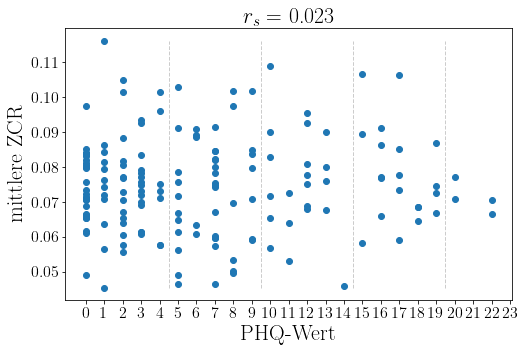

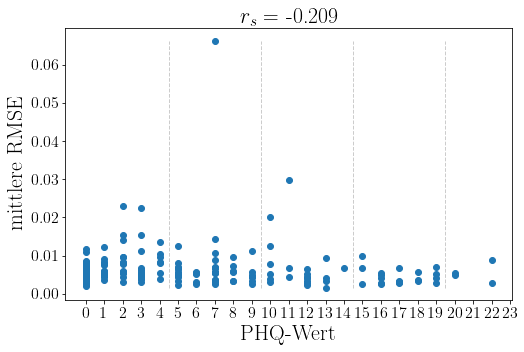

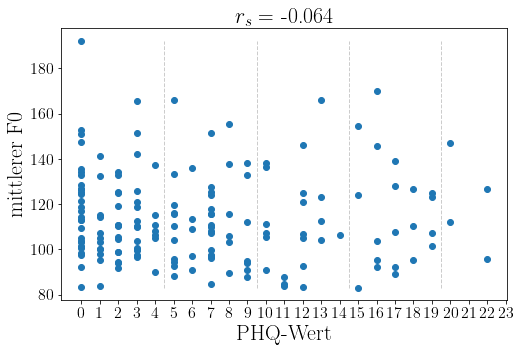

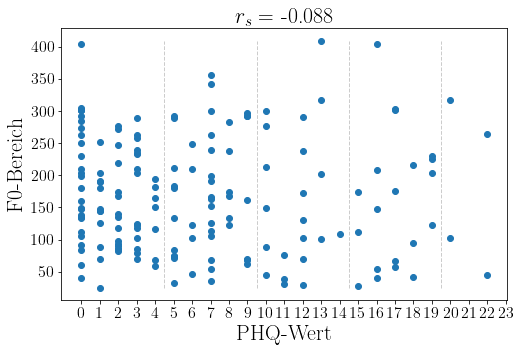

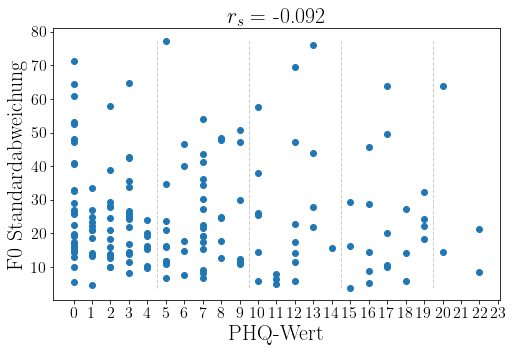

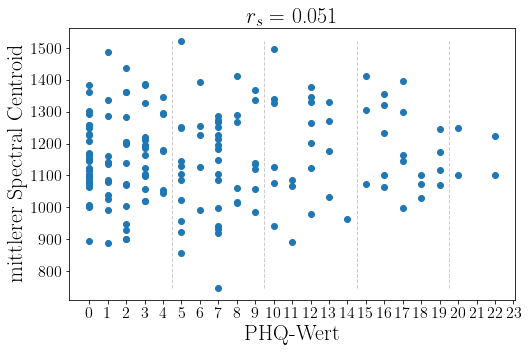

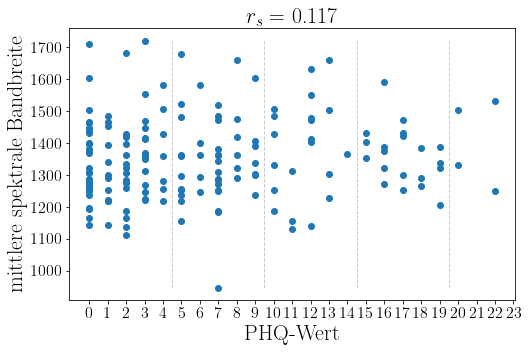

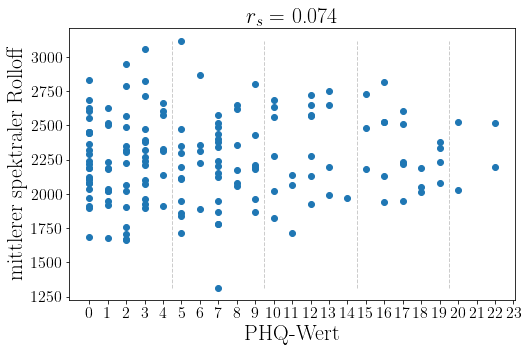

-------------------------------------------------------------------


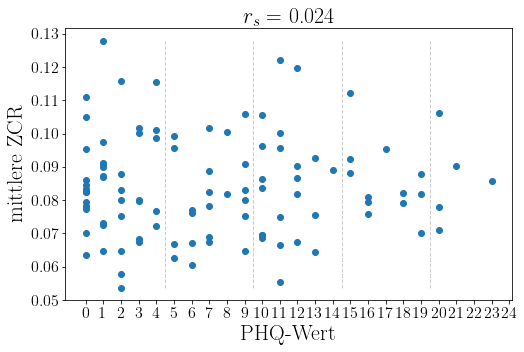

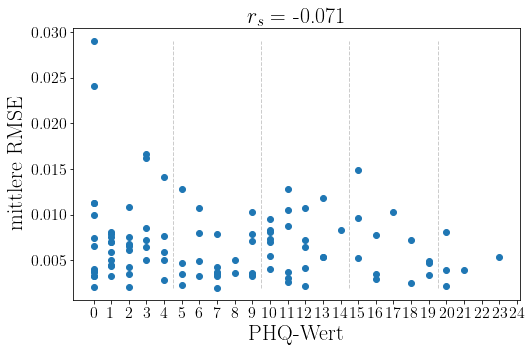

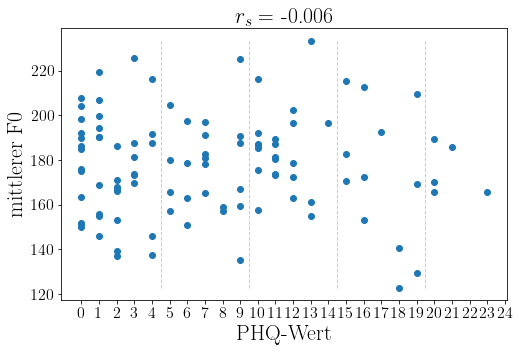

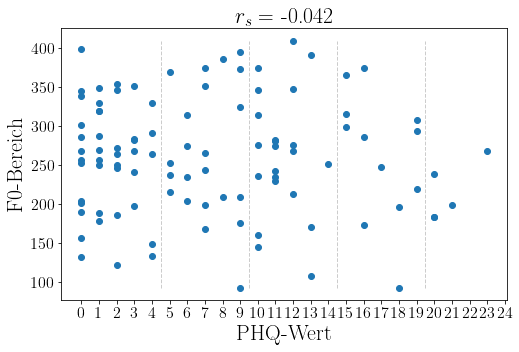

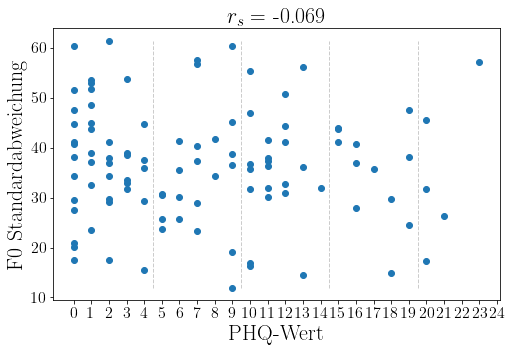

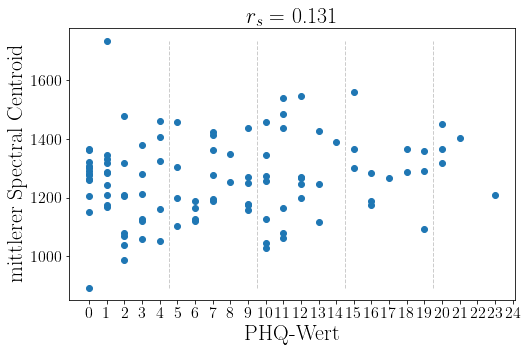

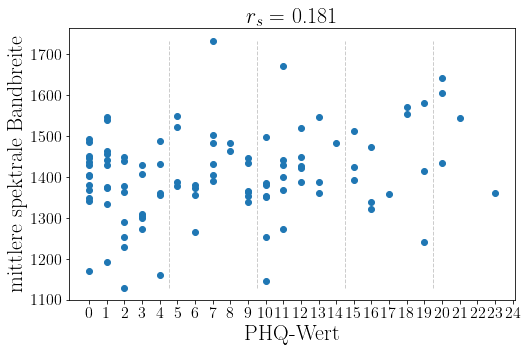

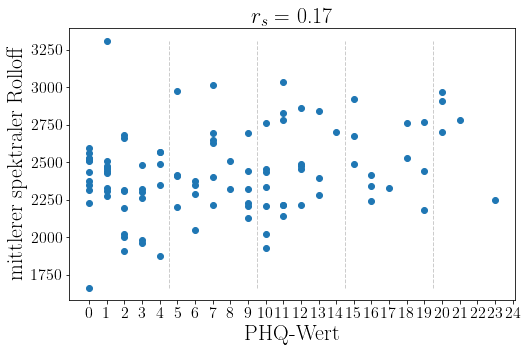

In [51]:

def plot_scatter(x, y, x_label, y_label, plot_title, x_ticks=None, axis_font_size=12, ticks_font_size=11, group='male'):
    plt.figure(figsize=(8, 5))
    plt.scatter(x, y)
    plt.xlabel(x_label, fontsize=axis_font_size)
    plt.ylabel(y_label, fontsize=axis_font_size)
    plt.xticks(x_ticks)
    plt.xticks(fontsize=ticks_font_size)
    plt.yticks(fontsize=ticks_font_size)
    plt.title(plot_title, fontsize=axis_font_size)
    
    #plot vlines to differentiate between phq-severities
    plt.vlines(4.5, min(y), max(y), linestyles='dashed', linewidth=1, colors='0.8')
    plt.vlines(9.5, min(y), max(y), linestyles='dashed', linewidth=1, colors='0.8')
    plt.vlines(14.5, min(y), max(y), linestyles='dashed', linewidth=1, colors='0.8')
    plt.vlines(19.5, min(y), max(y), linestyles='dashed', linewidth=1, colors='0.8')

    #plt.text(21, 0.06, 'matplotlib')
    #plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # No decimal places
    plt.savefig(f"{y_label}_{group}.svg")
    plt.show()

    
def set_y_label(str):
    if str == 'zcr_mean':
        return 'mittlere ZCR'
    elif str == 'rmse_mean':
        return 'mittlere RMSE'
    elif str == 'f0_mean':
        return 'mittlerer F0'
    elif str == 'f0_std':
        return 'F0 Standardabweichung'
    elif str == 'centroid_mean':
        return 'mittlerer Spectral Centroid'
    elif str == 'spec_bw_mean':
        return 'mittlere spektrale Bandbreite'
    elif str == 'rolloff_mean':
        return 'mittlerer spektraler Rolloff'
    elif str == 'f0_range':
        return 'F0-Bereich'

# plot for males
for k, v in group_stats['male'].items():
    if k not in ['x', 'spearman_coeffs']:
        spearman = group_stats['male']['spearman_coeffs'][k][0]
        plot_scatter(group_stats['male']['x'], 
                 v, 
                 'PHQ-Wert',
                 set_y_label(k),
                 r'$r_{s}=$' + f" {round(spearman, 3)}", 
                 x_ticks=range(0, 25),
                 axis_font_size=22,
                 ticks_font_size=16)

        
print("-------------------------------------------------------------------")


# plot for females
for k, v in group_stats['female'].items():
    if k not in ['x', 'spearman_coeffs']:
        spearman = group_stats['female']['spearman_coeffs'][k][0]
        plot_scatter(group_stats['female']['x'], 
                 v, 
                 'PHQ-Wert',
                 set_y_label(k),
                 r'$r_{s}=$' + f" {round(spearman, 3)}",  
                 x_ticks=range(0, 25),
                 axis_font_size=22,
                 ticks_font_size=16,
                 group='female')        
        